In [1]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
import datetime
from dateutil.relativedelta import relativedelta

from tqdm import tqdm_notebook
import tqdm

import pickle

import os
import warnings

warnings.filterwarnings('ignore')

In [2]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, \
                            accuracy_score, auc, precision_recall_curve, r2_score

In [3]:
import matplotlib.pylab as plt
import seaborn as sns

In [4]:
n_days = 20

start_date = datetime.datetime(2023, 4, 3)

start_dates = [start_date + relativedelta(days = i) for i in range(n_days + 1)]
start_dates = [i.date().strftime('%Y_%m_%d') for i in start_dates]

In [5]:
df = pd.DataFrame()

pair_1 = 'BTCUSDT'
pair_2 = 'BTCEUR'

tc = 'received_time_r'

for date in start_dates:
    
    lt_df_1 = pd.read_csv(f'~/LAST_TRADE_{pair_1}_{date}_5.csv').rename(columns = {'event_time_r': 'received_time_r'})
    lt_df_2 = pd.read_csv(f'~/LAST_TRADE_{pair_2}_{date}_5.csv').rename(columns = {'event_time_r': 'received_time_r'})
    
    lt_df_1.columns = [tc] + [i + '_LT' for i in lt_df_1.columns[1:]]
    lt_df_2.columns = [tc] + [i + '_LT' for i in lt_df_2.columns[1:]]
    
    lt_df_1['symbol'] = pair_1
    lt_df_2['symbol'] = pair_2

    df = df.append(lt_df_1, ignore_index = True).append(lt_df_2, ignore_index = True)

extremes = dict()

for c in df.columns[1:-2]:
    if df[c].max() == np.inf or df[c].max() > np.inf:
        extremes[c] = 1
    elif df[c].min() == -np.inf or df[c].min() < -np.inf:
        extremes[c] = 1
    else:
        pass
    
for c in extremes.keys():
    df[c] = np.where(df[c] >= np.inf, df[c][df[c] < np.inf].quantile(0.9), df[c])
    df[c] = np.where(df[c] <= -np.inf, df[c][df[c] > -np.inf].quantile(0.1), df[c])
    

no_variation = dict()

for c in df.columns[1:-2]:
    if np.nanstd(df[c]) == 0:
        no_variation[c] = 1

df.drop(columns = no_variation.keys(), inplace = True) 

df['minute'] = df['received_time_r'].apply(lambda x: x[-5:-3])
df['second'] = df['received_time_r'].apply(lambda x: x[-2:])

minutes_df = pd.get_dummies(df['minute'], prefix = 'minute', drop_first = True).astype(int)
seconds_df = pd.get_dummies(df['second'], prefix = 'second', drop_first = True).astype(int)

df.drop(columns = ['minute', 'second'], inplace = True)

df = pd.concat([df, minutes_df], axis = 1)
df = pd.concat([df, seconds_df], axis = 1)

del minutes_df
del seconds_df

df['received_time_r'] = df['received_time_r'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))


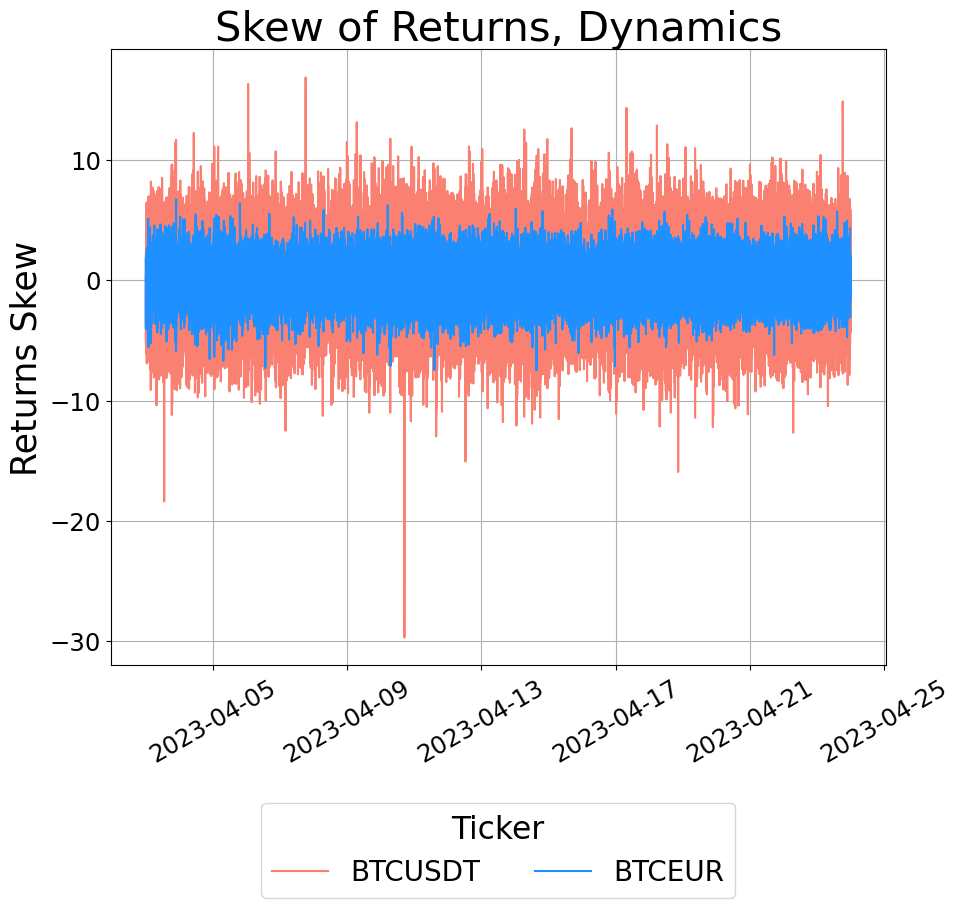

In [175]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'received_time_r', y = 'return_skew_l1_LT', 
             hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.4))
plt.grid()
plt.xlabel('')
plt.ylabel('Returns Skew', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Skew of Returns, Dynamics', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Skew of Returns, Dynamics.png', bbox_inches = 'tight')
plt.show()

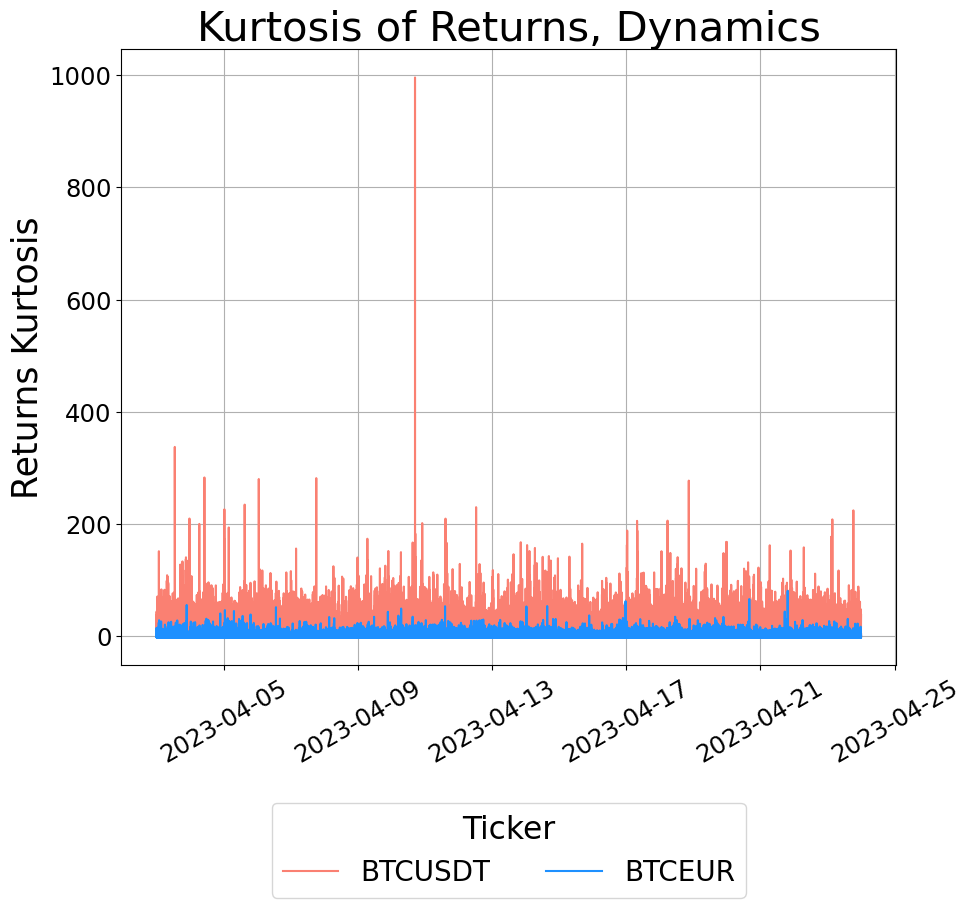

In [177]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'received_time_r', y = 'return_kurt_l1_LT', 
             hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.4))
plt.grid()
plt.xlabel('')
plt.ylabel('Returns Kurtosis', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Kurtosis of Returns, Dynamics', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Kurtosis of Returns, Dynamics.png', bbox_inches = 'tight')
plt.show()

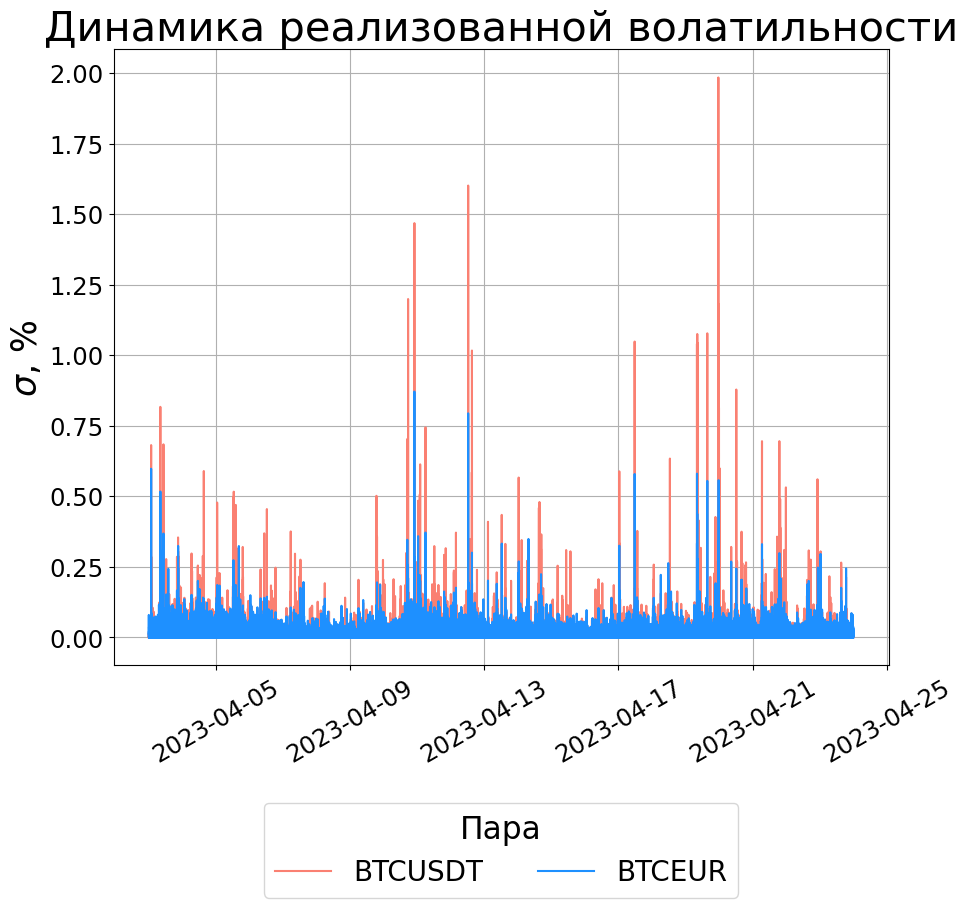

In [9]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'received_time_r', y = 'rv_LT', 
             hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Пара', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.4))
plt.grid()
plt.xlabel('')
plt.ylabel('$\sigma$, %', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Динамика реализованной волатильности', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('For Presentation Realized Variance, Dynamics.png', bbox_inches = 'tight')
plt.show()

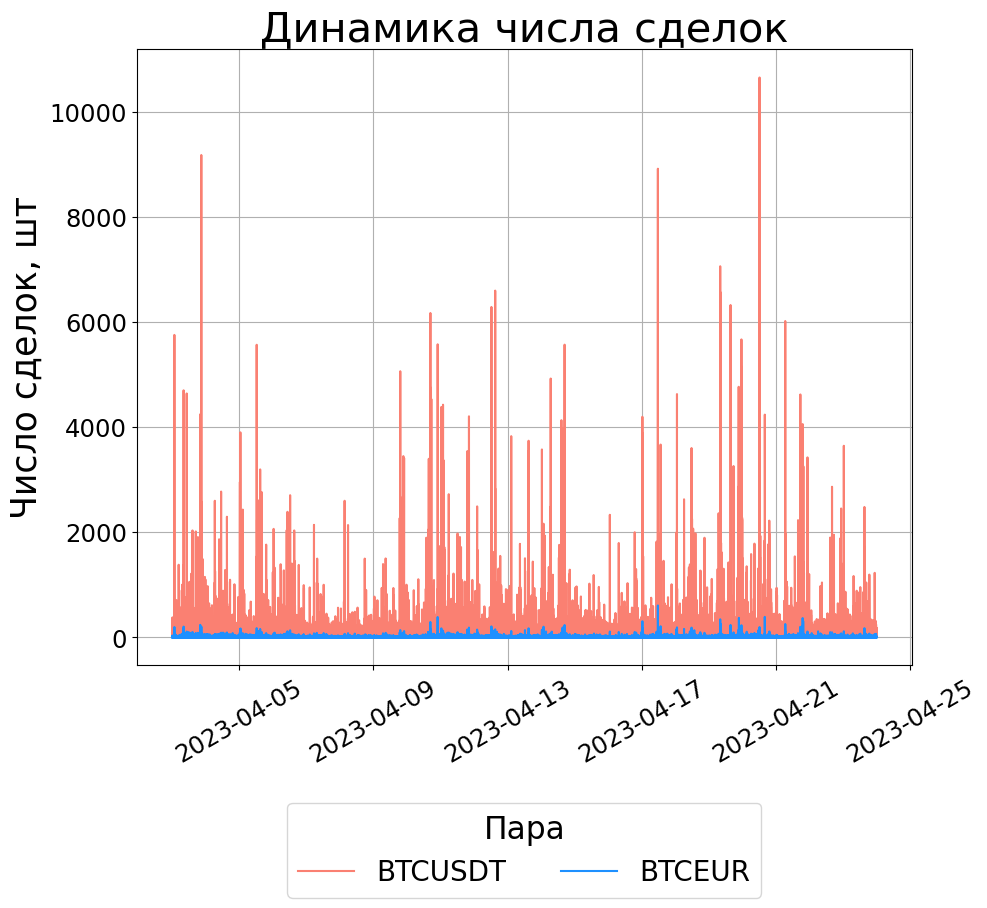

In [6]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'received_time_r', y = 'n_trades_l1_LT', 
             hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Пара', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.4))
plt.grid()
plt.xlabel('')
plt.ylabel('Число сделок, шт', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Динамика числа сделок', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('For Presentation Number of trades, Dynamics.png', bbox_inches = 'tight')
plt.show()

In [7]:
df['second'] = df['received_time_r'].apply(lambda x: x.second)
df['minute'] = df['received_time_r'].apply(lambda x: x.minute)

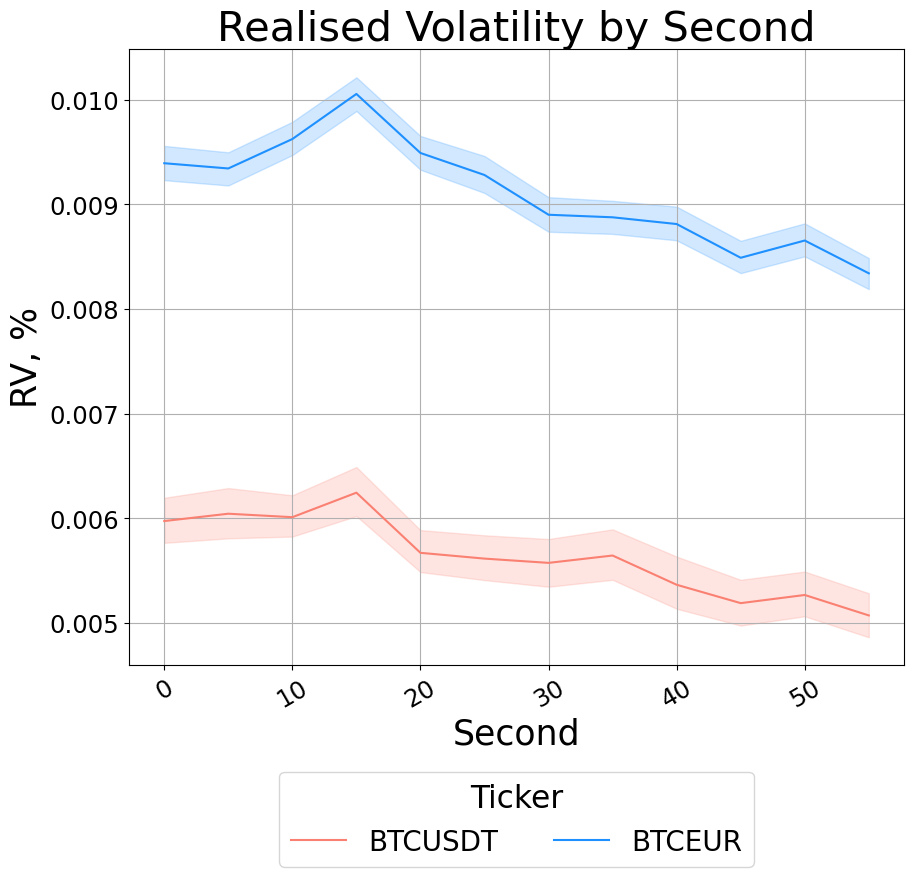

In [193]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'second', y = 'rv_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Second', fontsize = 25)
plt.ylabel('RV, %', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Realised Volatility by Second', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Realised Volatility by Second.png', bbox_inches = 'tight')
plt.show()

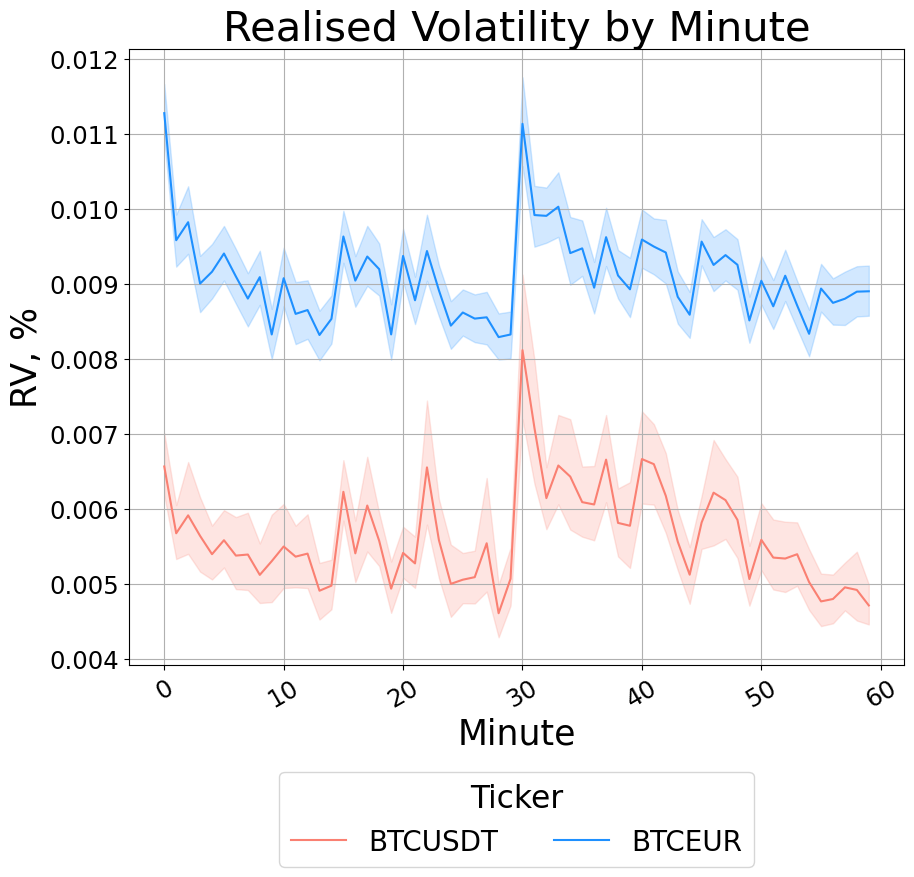

In [194]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'minute', y = 'rv_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Minute', fontsize = 25)
plt.ylabel('RV, %', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Realised Volatility by Minute', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Realised Volatility by Minute.png', bbox_inches = 'tight')
plt.show()

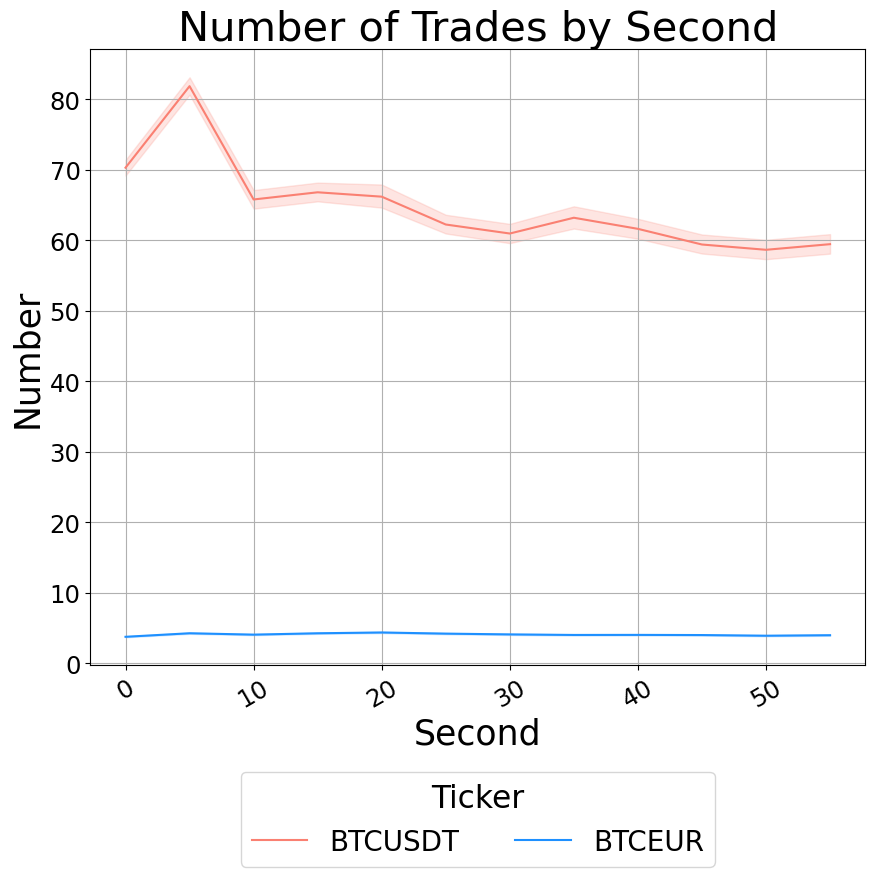

In [195]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'second', y = 'n_trades_l1_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Second', fontsize = 25)
plt.ylabel('Number', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Number of Trades by Second', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Number of Trades by Second.png', bbox_inches = 'tight')
plt.show()

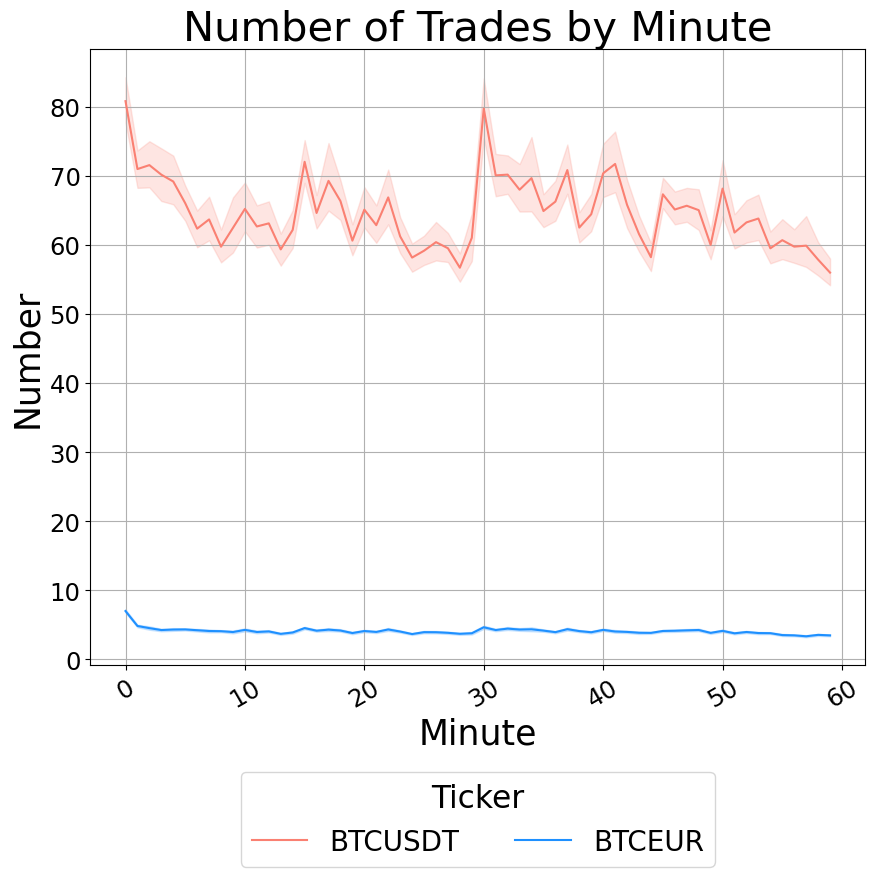

In [196]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'minute', y = 'n_trades_l1_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Minute', fontsize = 25)
plt.ylabel('Number', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Number of Trades by Minute', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Number of Trades by Minute.png', bbox_inches = 'tight')
plt.show()

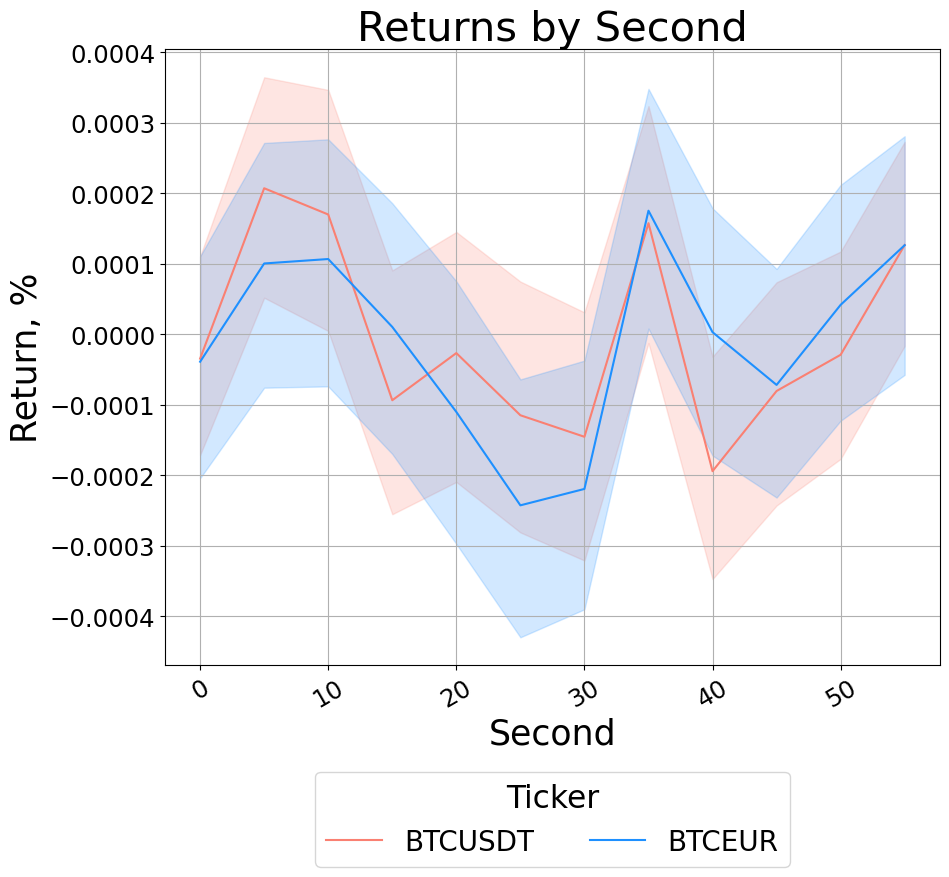

In [198]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'second', y = 'return_last_l1_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Second', fontsize = 25)
plt.ylabel('Return, %', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Returns by Second', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Returns by Second.png', bbox_inches = 'tight')
plt.show()

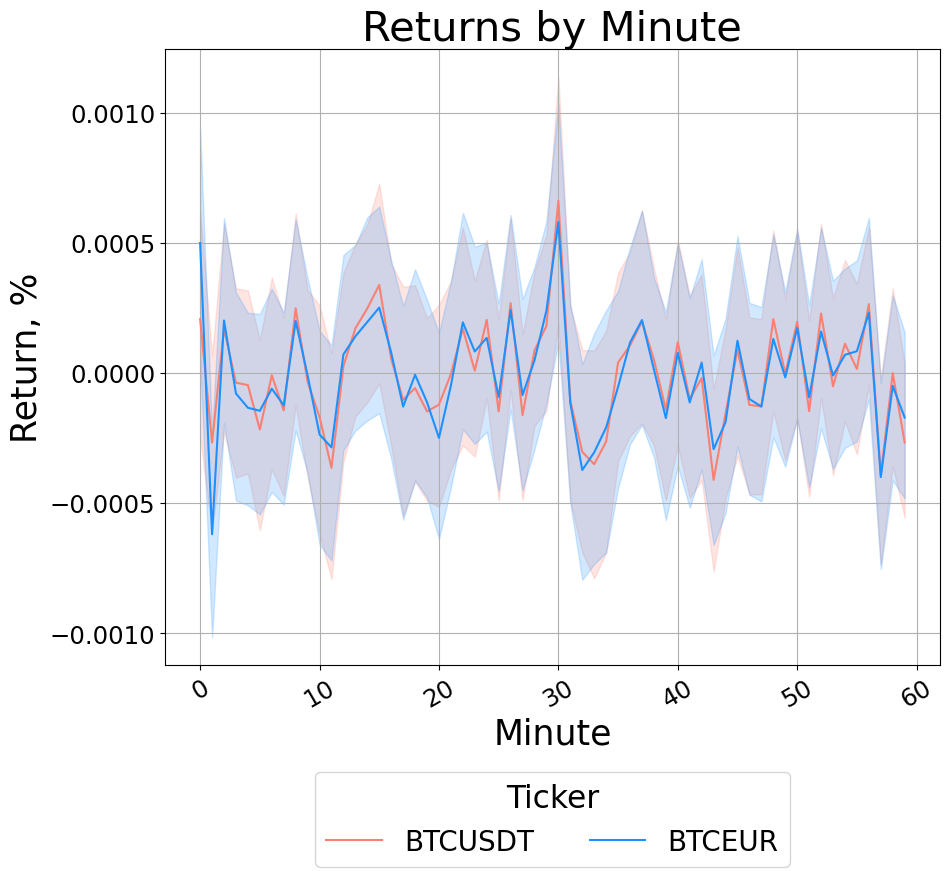

In [199]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'minute', y = 'return_last_l1_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Minute', fontsize = 25)
plt.ylabel('Return, %', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Returns by Minute', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Returns by Minute.png', bbox_inches = 'tight')
plt.show()

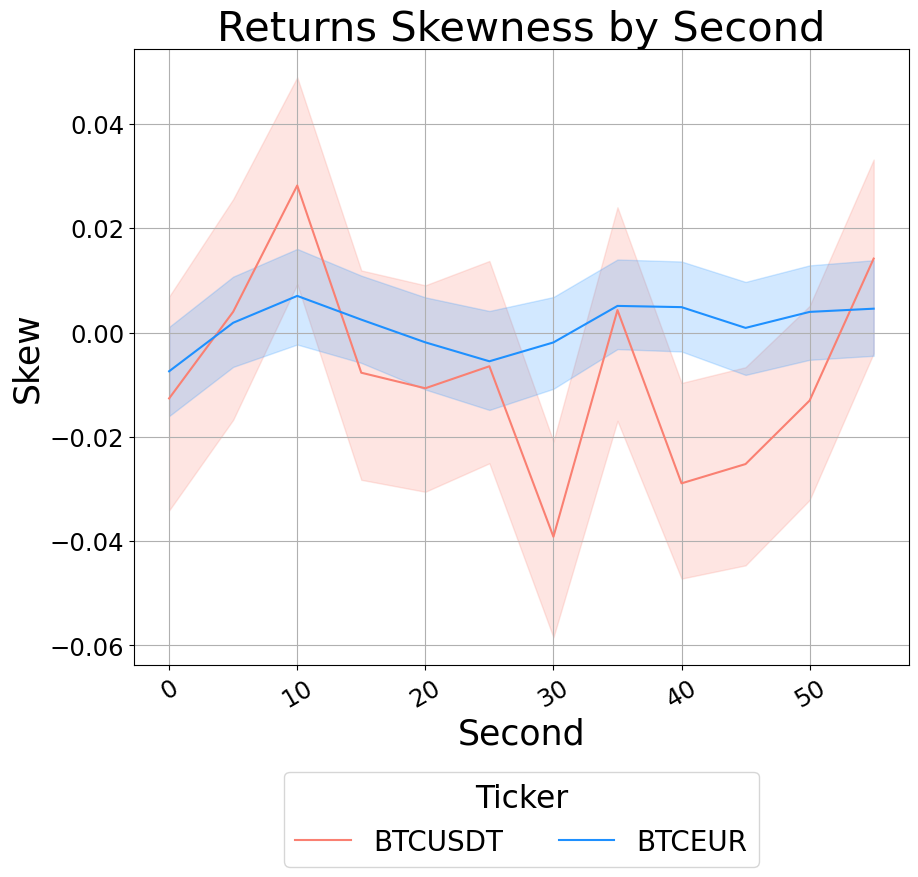

In [201]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'second', y = 'return_skew_l1_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Second', fontsize = 25)
plt.ylabel('Skew', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Returns Skewness by Second', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Returns Skewness by Second.png', bbox_inches = 'tight')
plt.show()

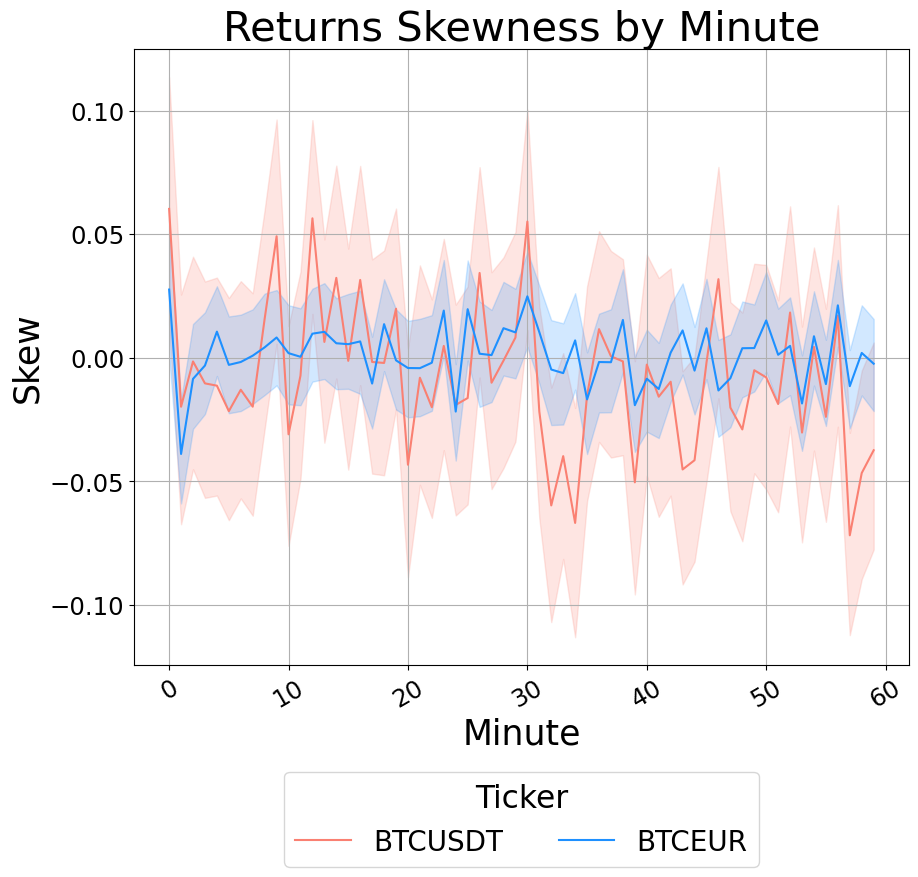

In [200]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'minute', y = 'return_skew_l1_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Minute', fontsize = 25)
plt.ylabel('Skew', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Returns Skewness by Minute', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Returns Skewness by Minute.png', bbox_inches = 'tight')
plt.show()

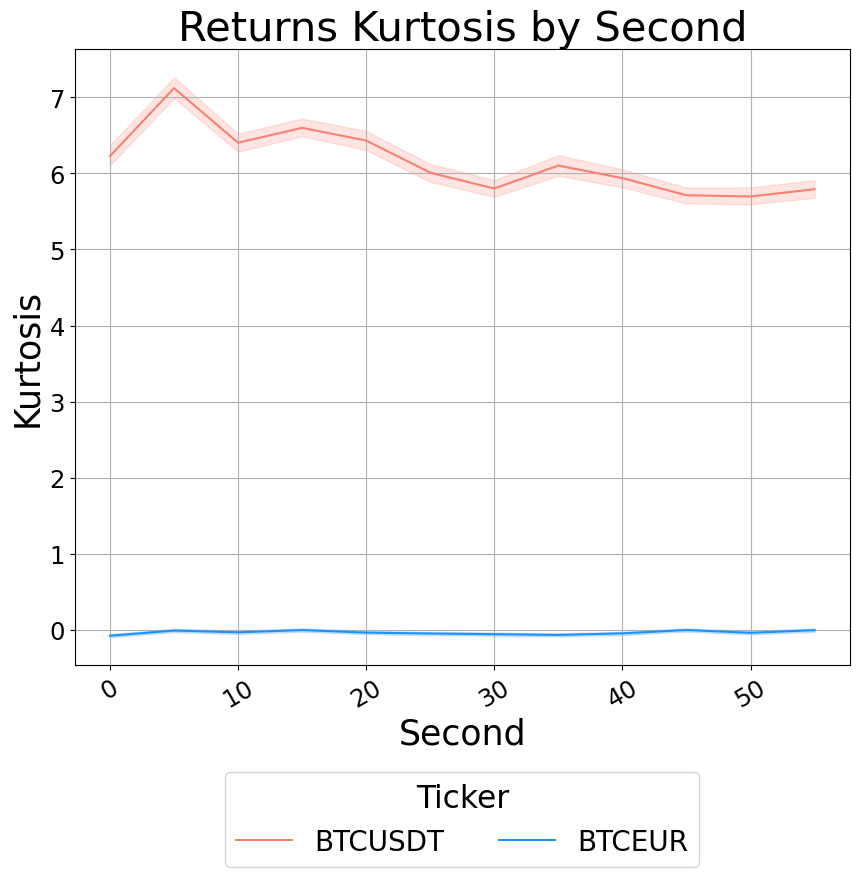

In [202]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'second', y = 'return_kurt_l1_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Second', fontsize = 25)
plt.ylabel('Kurtosis', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Returns Kurtosis by Second', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Returns Kurtosis by Second.png', bbox_inches = 'tight')
plt.show()

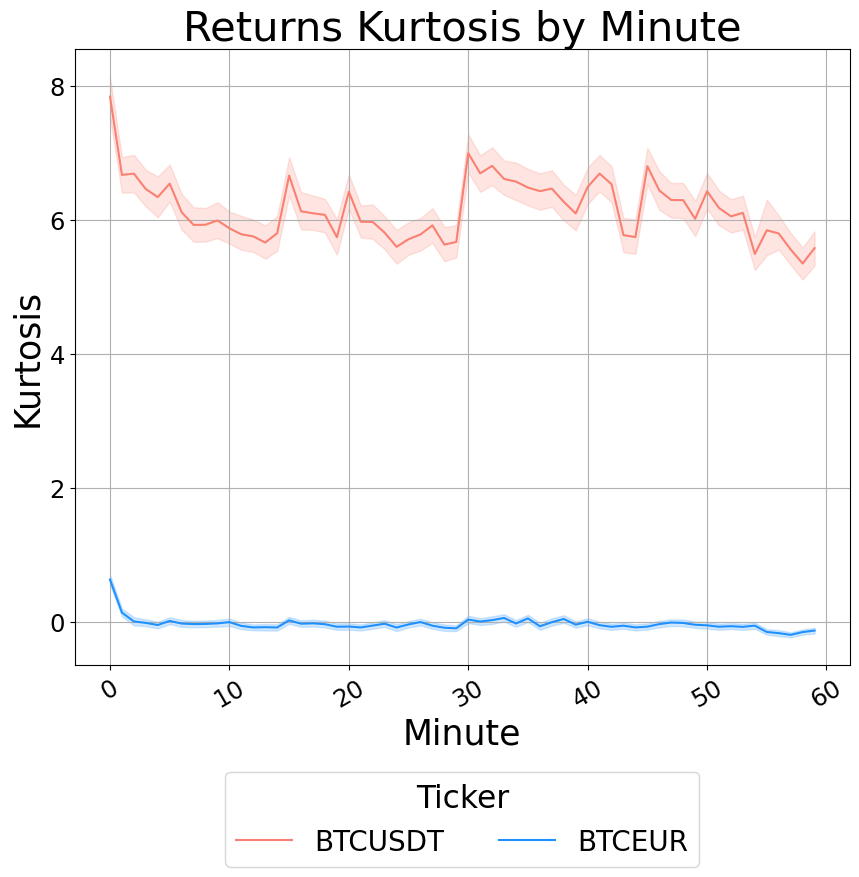

In [203]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = df, x = 'minute', y = 'return_kurt_l1_LT',
            hue = 'symbol', palette = ['salmon', 'dodgerblue'])

plt.legend(fontsize = 20, title = 'Ticker', title_fontsize = 22.5, ncol = 2, loc = 'lower center',
           bbox_to_anchor = (0.5, -0.35))
plt.grid()
plt.xlabel('Minute', fontsize = 25)
plt.ylabel('Kurtosis', fontsize = 25)
plt.tick_params(labelsize = 17.5)
plt.title('Returns Kurtosis by Minute', fontsize = 30)
plt.xticks(rotation = 30)
plt.savefig('Returns Kurtosis by Minute.png', bbox_inches = 'tight')
plt.show()

In [ ]:
df = df.drop(columns = ['second', 'minute'])

In [150]:
def mae(y_true, y_pred):
    return np.nanmean(abs(y_true - y_pred))

def rmae(y_true, y_pred):
    return mae(y_true, y_pred) / np.nanmean(y_true)

def sliding_window_cv(data, target, min_sample, timestamp_col, window, algorythm, algo_params, freq,
                      scaling = False):
    
    date_col = 'date_col'
    symbol_col = 'symbol'
    
    data[date_col] = data[timestamp_col].apply(lambda x: x.date())
    start_date, end_date = data[date_col].min(), data[date_col].max()
    
    delta = (end_date - start_date).days
    n_iter = delta - window - min_sample + 1
    
    results = dict()
    
    l = int(data.shape[0] * 0.1)
    
    for i in tqdm.tqdm_notebook(range(n_iter + 1)):
        delta = relativedelta(days = +i)
        start, end = start_date + delta, start_date + delta + relativedelta(days = +min_sample)
        
        train = data[(data[date_col] >= start) & (data[date_col] < end)]
        test = data[(data[date_col] >= end) & (data[date_col] < end + relativedelta(days = +window))]
        
        print(train[date_col].min(), train[date_col].max(), test[date_col].unique())
        
        x_train, y_train = train.drop(columns = [target, timestamp_col, date_col, symbol_col]), train[target]
        x_test, y_test = test.drop(columns = [target, timestamp_col, date_col, symbol_col]), test[target]
        
        if scaling:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)
            
        model = algorythm(**algo_params)
        model.fit(x_train, y_train)
        
        file_name = f"xgb_both_tickers_sw_cv_{datetime.datetime.strftime(start, '%Y_%m_%d')}_w{window}_freq{freq}.pkl"
        pickle.dump(model, open(file_name, "wb"))
        
        y_pred = model.predict(x_test)
        
        y_pred_usd = y_pred[test[symbol_col] == 'BTCUSDT']
        y_pred_eur = y_pred[test[symbol_col] == 'BTCEUR']
        
        y_test_usd = y_test[test[symbol_col] == 'BTCUSDT']
        y_test_eur = y_test[test[symbol_col] == 'BTCEUR']
        
        y_train_usd = y_train[train[symbol_col] == 'BTCUSDT']
        y_train_eur = y_train[train[symbol_col] == 'BTCEUR']
        
        threshold_usd = np.nanquantile(y_pred_usd[:l], (y_train_usd == 0).mean())
        threshold_eur = np.nanquantile(y_pred_usd[:l], (y_train_usd == 0).mean())

        y_pred_usd_bin = np.where(y_pred_usd[l:] < threshold_usd, 1, 0)
        y_pred_eur_bin = np.where(y_pred_eur[l:] < threshold_eur, 1, 0)
        y_test_usd_bin = np.where(y_test_usd[l:] == 0, 1, 0)
        y_test_eur_bin = np.where(y_test_eur[l:] == 0, 1, 0)

        recall_usd = recall_score(y_test_usd_bin, y_pred_usd_bin)
        recall_eur = recall_score(y_test_eur_bin, y_pred_eur_bin)
        precision_usd = precision_score(y_test_usd_bin, y_pred_usd_bin)
        precision_eur = precision_score(y_test_eur_bin, y_pred_eur_bin)
        f1_usd = f1_score(y_test_usd_bin, y_pred_usd_bin)
        f1_eur = f1_score(y_test_eur_bin, y_pred_eur_bin)
        r2_usd = r2_score(y_test_usd, y_pred_usd)
        r2_eur = r2_score(y_test_eur, y_pred_eur)
        r2_rw_usd = r2_score(y_test_usd[:-1], y_test_usd[1:])
        r2_rw_eur = r2_score(y_test_eur[:-1], y_test_eur[1:])

        mae_model_usd = abs(y_pred_usd - y_test_usd)[1:]
        mae_model_eur = abs(y_pred_eur - y_test_eur)[1:]
        
        mae_rw_usd = abs(y_test_usd[1:] - y_test_usd[:-1])
        mae_rw_eur = abs(y_test_eur[1:] - y_test_eur[:-1])
        
        mae_avg_usd = abs(y_test_usd - y_train_usd.mean())
        mae_avg_eur = abs(y_test_eur - y_train_eur.mean())

        diff_rw_usd = mae_rw_usd - mae_model_usd
        diff_rw_eur = mae_rw_eur - mae_model_eur
        
        tstat_rw_usd = diff_rw_usd.mean() / diff_rw_usd.std() * np.sqrt(diff_rw_usd.shape[0] - 1)
        tstat_rw_eur = diff_rw_eur.mean() / diff_rw_eur.std() * np.sqrt(diff_rw_eur.shape[0] - 1)

        diff_avg_usd = mae_avg_usd - mae_model_usd
        diff_avg_eur = mae_avg_eur - mae_model_eur
        
        tstat_avg_usd = diff_avg_usd.mean() / diff_avg_usd.std() * np.sqrt(diff_avg_usd.shape[0] - 1)
        tstat_avg_eur = diff_avg_eur.mean() / diff_avg_eur.std() * np.sqrt(diff_avg_eur.shape[0] - 1)
        
        fi = pd.DataFrame(zip(train.drop(columns = [target, timestamp_col, date_col]).columns, 
                              model.feature_importances_), 
                          columns = ['feature', 'importance']).sort_values(by = 'importance', ascending = False)
        
        fi.to_excel(f'FI_BOTH_TICKERS_SW_freq{freq}.xlsx', index = None)
        
        eur = {'mae': mae(y_test_eur, y_pred_eur), 'rmae': rmae(y_test_eur, y_pred_eur),
               'recall': recall_eur, 'precision': precision_eur, 'f1': f1_eur,
               'r2': r2_eur, 'r2_rw': r2_rw_eur, 'tstat_rw': tstat_rw_eur, 'tstat_avg': tstat_avg_eur,
               'avg_zero_test': y_test_eur_bin.mean(), 'avg_zero_pred': y_pred_eur_bin.mean(),
              }
        
        usd = {'mae': mae(y_test_usd, y_pred_usd), 'rmae': rmae(y_test_usd, y_pred_usd),
               'recall': recall_usd, 'precision': precision_usd, 'f1': f1_usd,
               'r2': r2_usd, 'r2_rw': r2_rw_usd, 'tstat_rw': tstat_rw_usd, 'tstat_avg': tstat_avg_usd,
               'avg_zero_test': y_test_usd_bin.mean(), 'avg_zero_pred': y_pred_usd_bin.mean(),
              }
        
        results[end] = {'eur': eur,
                        'usd': usd,
                        'fi': fi}
        
    return results
    

def expanding_window_cv(data, target, min_sample, timestamp_col, window, algorythm, algo_params, freq,
                        scaling = False):
    
    date_col = 'date_col'
    symbol_col = 'symbol'
    
    data[date_col] = data[timestamp_col].apply(lambda x: x.date())
    start_date, end_date = data[date_col].min(), data[date_col].max()
    
    delta = (end_date - start_date).days
    n_iter = delta - window - min_sample + 1
    
    results = dict()
    
    l = int(data.shape[0] * 0.1)
    
    for i in tqdm.tqdm_notebook(range(n_iter + 1)):
        delta = relativedelta(days = +i)
        start, end = start_date, start_date + delta + relativedelta(days = +min_sample)
        
        train = data[(data[date_col] >= start) & (data[date_col] < end)]
        test = data[(data[date_col] >= end) & (data[date_col] < end + relativedelta(days = +window))]
        
        print(train[date_col].min(), train[date_col].max(), test[date_col].unique())
        
        x_train, y_train = train.drop(columns = [target, timestamp_col, date_col, symbol_col]), train[target]
        x_test, y_test = test.drop(columns = [target, timestamp_col, date_col, symbol_col]), test[target]
        
        if scaling:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)
            
        model = algorythm(**algo_params)
        model.fit(x_train, y_train)
        
        file_name = f"xgb_both_tickers_ew_cv_{datetime.datetime.strftime(start, '%Y_%m_%d')}_w{window}_freq{freq}.pkl"
        pickle.dump(model, open(file_name, "wb"))
        
        y_pred = model.predict(x_test)
        
        y_pred_usd = y_pred[test[symbol_col] == 'BTCUSDT']
        y_pred_eur = y_pred[test[symbol_col] == 'BTCEUR']
        
        y_test_usd = y_test[test[symbol_col] == 'BTCUSDT']
        y_test_eur = y_test[test[symbol_col] == 'BTCEUR']
        
        y_train_usd = y_train[train[symbol_col] == 'BTCUSDT']
        y_train_eur = y_train[train[symbol_col] == 'BTCEUR']
        
        threshold_usd = np.nanquantile(y_pred_usd[:l], (y_train_usd == 0).mean())
        threshold_eur = np.nanquantile(y_pred_usd[:l], (y_train_usd == 0).mean())

        y_pred_usd_bin = np.where(y_pred_usd[l:] < threshold_usd, 1, 0)
        y_pred_eur_bin = np.where(y_pred_eur[l:] < threshold_eur, 1, 0)
        y_test_usd_bin = np.where(y_test_usd[l:] == 0, 1, 0)
        y_test_eur_bin = np.where(y_test_eur[l:] == 0, 1, 0)

        recall_usd = recall_score(y_test_usd_bin, y_pred_usd_bin)
        recall_eur = recall_score(y_test_eur_bin, y_pred_eur_bin)
        precision_usd = precision_score(y_test_usd_bin, y_pred_usd_bin)
        precision_eur = precision_score(y_test_eur_bin, y_pred_eur_bin)
        f1_usd = f1_score(y_test_usd_bin, y_pred_usd_bin)
        f1_eur = f1_score(y_test_eur_bin, y_pred_eur_bin)
        r2_usd = r2_score(y_test_usd, y_pred_usd)
        r2_eur = r2_score(y_test_eur, y_pred_eur)
        r2_rw_usd = r2_score(y_test_usd[:-1], y_test_usd[1:])
        r2_rw_eur = r2_score(y_test_eur[:-1], y_test_eur[1:])

        mae_model_usd = abs(y_pred_usd - y_test_usd)[1:]
        mae_model_eur = abs(y_pred_eur - y_test_eur)[1:]
        
        mae_rw_usd = abs(y_test_usd[1:] - y_test_usd[:-1])
        mae_rw_eur = abs(y_test_eur[1:] - y_test_eur[:-1])
        
        mae_avg_usd = abs(y_test_usd - y_train_usd.mean())
        mae_avg_eur = abs(y_test_eur - y_train_eur.mean())

        diff_rw_usd = mae_rw_usd - mae_model_usd
        diff_rw_eur = mae_rw_eur - mae_model_eur
        
        tstat_rw_usd = diff_rw_usd.mean() / diff_rw_usd.std() * np.sqrt(diff_rw_usd.shape[0] - 1)
        tstat_rw_eur = diff_rw_eur.mean() / diff_rw_eur.std() * np.sqrt(diff_rw_eur.shape[0] - 1)

        diff_avg_usd = mae_avg_usd - mae_model_usd
        diff_avg_eur = mae_avg_eur - mae_model_eur
        
        tstat_avg_usd = diff_avg_usd.mean() / diff_avg_usd.std() * np.sqrt(diff_avg_usd.shape[0] - 1)
        tstat_avg_eur = diff_avg_eur.mean() / diff_avg_eur.std() * np.sqrt(diff_avg_eur.shape[0] - 1)
        
        fi = pd.DataFrame(zip(train.drop(columns = [target, timestamp_col, date_col]).columns, 
                              model.feature_importances_), 
                          columns = ['feature', 'importance']).sort_values(by = 'importance', ascending = False)
        
        fi.to_excel(f'FI_BOTH_TICKERS_EW_freq{freq}.xlsx', index = None)
        
        eur = {'mae': mae(y_test_eur, y_pred_eur), 'rmae': rmae(y_test_eur, y_pred_eur),
               'recall': recall_eur, 'precision': precision_eur, 'f1': f1_eur,
               'r2': r2_eur, 'r2_rw': r2_rw_eur, 'tstat_rw': tstat_rw_eur, 'tstat_avg': tstat_avg_eur,
               'avg_zero_test': y_test_eur_bin.mean(), 'avg_zero_pred': y_pred_eur_bin.mean(),
              }
        
        usd = {'mae': mae(y_test_usd, y_pred_usd), 'rmae': rmae(y_test_usd, y_pred_usd),
               'recall': recall_usd, 'precision': precision_usd, 'f1': f1_usd,
               'r2': r2_usd, 'r2_rw': r2_rw_usd, 'tstat_rw': tstat_rw_usd, 'tstat_avg': tstat_avg_usd,
               'avg_zero_test': y_test_usd_bin.mean(), 'avg_zero_pred': y_pred_usd_bin.mean(),
              }
        
        results[end] = {'eur': eur,
                        'usd': usd,
                        'fi': fi}
        
    return results
    


In [151]:
params = {
          'n_estimators': 500, 
          'max_depth': 6, 
          'learning_rate': 0.05, 
          'reg_alpha': 10, 
          'random_state': 81, 
          'n_jobs': 10
         }

In [152]:
freq = 1

In [153]:
res_sliding = sliding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, XGBRegressor, params, 10,
                                scaling = True)

  0%|          | 0/14 [00:00<?, ?it/s]

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-04 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-05 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-06 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-07 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-08 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-09 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-10 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-11 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-12 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-13 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-14 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-15 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-16 2023-04-22 [datetime.date(2023, 4, 23)]


In [154]:
sliding_results = pd.DataFrame({'date': [i for i in res_sliding.keys()],
                                'mae': [res_sliding[i]['eur']['mae'] for i, j in res_sliding.items()],
                                'rmae': [res_sliding[i]['eur']['rmae'] for i, j in res_sliding.items()],
                                'recall': [res_sliding[i]['eur']['recall'] for i, j in res_sliding.items()],
                                'precision': [res_sliding[i]['eur']['precision'] for i, j in res_sliding.items()],
                                'f1': [res_sliding[i]['eur']['f1'] for i, j in res_sliding.items()],
                                'r2': [res_sliding[i]['eur']['r2'] for i, j in res_sliding.items()], 
                                'r2_rw': [res_sliding[i]['eur']['r2_rw'] for i, j in res_sliding.items()],
                                'tstat_rw': [res_sliding[i]['eur']['tstat_rw'] for i, j in res_sliding.items()],
                                'tstat_avg': [res_sliding[i]['eur']['tstat_avg'] for i, j in res_sliding.items()],
                                'avg_zero_test': [res_sliding[i]['eur']['avg_zero_test'] for i, j in res_sliding.items()],
                                'avg_zero_pred': [res_sliding[i]['eur']['avg_zero_pred'] for i, j in res_sliding.items()]} 
                               )

sliding_results.to_excel(f'SW_BOTH_TICKERS_EUR_RESULTS_FREQ{freq}_BOOSTING.xlsx', index = None)

sliding_results = pd.DataFrame({'date': [i for i in res_sliding.keys()],
                                'mae': [res_sliding[i]['usd']['mae'] for i, j in res_sliding.items()],
                                'rmae': [res_sliding[i]['usd']['rmae'] for i, j in res_sliding.items()],
                                'recall': [res_sliding[i]['usd']['recall'] for i, j in res_sliding.items()],
                                'precision': [res_sliding[i]['usd']['precision'] for i, j in res_sliding.items()],
                                'f1': [res_sliding[i]['usd']['f1'] for i, j in res_sliding.items()],
                                'r2': [res_sliding[i]['usd']['r2'] for i, j in res_sliding.items()], 
                                'r2_rw': [res_sliding[i]['usd']['r2_rw'] for i, j in res_sliding.items()],
                                'tstat_rw': [res_sliding[i]['usd']['tstat_rw'] for i, j in res_sliding.items()],
                                'tstat_avg': [res_sliding[i]['usd']['tstat_avg'] for i, j in res_sliding.items()],
                                'avg_zero_test': [res_sliding[i]['usd']['avg_zero_test'] for i, j in res_sliding.items()],
                                'avg_zero_pred': [res_sliding[i]['usd']['avg_zero_pred'] for i, j in res_sliding.items()]} 
                               )

sliding_results.to_excel(f'SW_BOTH_TICKERS_USD_RESULTS_FREQ{freq}_BOOSTING.xlsx', index = None)


In [155]:
res_expanding = expanding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, XGBRegressor, params, 10,
                                    scaling = True)

  0%|          | 0/14 [00:00<?, ?it/s]

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-03 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-03 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-03 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-03 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-03 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-03 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-03 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-03 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-03 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-03 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-03 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-03 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-03 2023-04-22 [datetime.date(2023, 4, 23)]


In [156]:
expanding_results = pd.DataFrame({'date': [i for i in res_expanding.keys()],
                                'mae': [res_expanding[i]['eur']['mae'] for i, j in res_expanding.items()],
                                'rmae': [res_expanding[i]['eur']['rmae'] for i, j in res_expanding.items()],
                                'recall': [res_expanding[i]['eur']['recall'] for i, j in res_expanding.items()],
                                'precision': [res_expanding[i]['eur']['precision'] for i, j in res_expanding.items()],
                                'f1': [res_expanding[i]['eur']['f1'] for i, j in res_expanding.items()],
                                'r2': [res_expanding[i]['eur']['r2'] for i, j in res_expanding.items()], 
                                'r2_rw': [res_expanding[i]['eur']['r2_rw'] for i, j in res_expanding.items()],
                                'tstat_rw': [res_expanding[i]['eur']['tstat_rw'] for i, j in res_expanding.items()],
                                'tstat_avg': [res_expanding[i]['eur']['tstat_avg'] for i, j in res_expanding.items()],
                                'avg_zero_test': [res_expanding[i]['eur']['avg_zero_test'] for i, j in res_expanding.items()],
                                'avg_zero_pred': [res_expanding[i]['eur']['avg_zero_pred'] for i, j in res_expanding.items()]} 
                               )

expanding_results.to_excel(f'EW_BOTH_TICKERS_EUR_RESULTS_FREQ{freq}_BOOSTING.xlsx', index = None)

expanding_results = pd.DataFrame({'date': [i for i in res_expanding.keys()],
                                'mae': [res_expanding[i]['usd']['mae'] for i, j in res_expanding.items()],
                                'rmae': [res_expanding[i]['usd']['rmae'] for i, j in res_expanding.items()],
                                'recall': [res_expanding[i]['usd']['recall'] for i, j in res_expanding.items()],
                                'precision': [res_expanding[i]['usd']['precision'] for i, j in res_expanding.items()],
                                'f1': [res_expanding[i]['usd']['f1'] for i, j in res_expanding.items()],
                                'r2': [res_expanding[i]['usd']['r2'] for i, j in res_expanding.items()], 
                                'r2_rw': [res_expanding[i]['usd']['r2_rw'] for i, j in res_expanding.items()],
                                'tstat_rw': [res_expanding[i]['usd']['tstat_rw'] for i, j in res_expanding.items()],
                                'tstat_avg': [res_expanding[i]['usd']['tstat_avg'] for i, j in res_expanding.items()],
                                'avg_zero_test': [res_expanding[i]['usd']['avg_zero_test'] for i, j in res_expanding.items()],
                                'avg_zero_pred': [res_expanding[i]['usd']['avg_zero_pred'] for i, j in res_expanding.items()]} 
                               )

expanding_results.to_excel(f'EW_BOTH_TICKERS_USD_RESULTS_FREQ{freq}_BOOSTING.xlsx', index = None)


In [157]:
params = {
          'n_estimators': 500, 
          'max_depth': 6,  
          'random_state': 81, 
          'n_jobs': 10
         }

In [158]:
res_sliding = sliding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, RandomForestRegressor, params, 10,
                                scaling = True)

  0%|          | 0/14 [00:00<?, ?it/s]

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-04 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-05 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-06 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-07 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-08 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-09 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-10 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-11 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-12 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-13 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-14 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-15 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-16 2023-04-22 [datetime.date(2023, 4, 23)]


In [159]:
sliding_results = pd.DataFrame({'date': [i for i in res_sliding.keys()],
                                'mae': [res_sliding[i]['eur']['mae'] for i, j in res_sliding.items()],
                                'rmae': [res_sliding[i]['eur']['rmae'] for i, j in res_sliding.items()],
                                'recall': [res_sliding[i]['eur']['recall'] for i, j in res_sliding.items()],
                                'precision': [res_sliding[i]['eur']['precision'] for i, j in res_sliding.items()],
                                'f1': [res_sliding[i]['eur']['f1'] for i, j in res_sliding.items()],
                                'r2': [res_sliding[i]['eur']['r2'] for i, j in res_sliding.items()], 
                                'r2_rw': [res_sliding[i]['eur']['r2_rw'] for i, j in res_sliding.items()],
                                'tstat_rw': [res_sliding[i]['eur']['tstat_rw'] for i, j in res_sliding.items()],
                                'tstat_avg': [res_sliding[i]['eur']['tstat_avg'] for i, j in res_sliding.items()],
                                'avg_zero_test': [res_sliding[i]['eur']['avg_zero_test'] for i, j in res_sliding.items()],
                                'avg_zero_pred': [res_sliding[i]['eur']['avg_zero_pred'] for i, j in res_sliding.items()]} 
                               )

sliding_results.to_excel(f'SW_BOTH_TICKERS_EUR_RESULTS_FREQ{freq}_RF.xlsx', index = None)

sliding_results = pd.DataFrame({'date': [i for i in res_sliding.keys()],
                                'mae': [res_sliding[i]['usd']['mae'] for i, j in res_sliding.items()],
                                'rmae': [res_sliding[i]['usd']['rmae'] for i, j in res_sliding.items()],
                                'recall': [res_sliding[i]['usd']['recall'] for i, j in res_sliding.items()],
                                'precision': [res_sliding[i]['usd']['precision'] for i, j in res_sliding.items()],
                                'f1': [res_sliding[i]['usd']['f1'] for i, j in res_sliding.items()],
                                'r2': [res_sliding[i]['usd']['r2'] for i, j in res_sliding.items()], 
                                'r2_rw': [res_sliding[i]['usd']['r2_rw'] for i, j in res_sliding.items()],
                                'tstat_rw': [res_sliding[i]['usd']['tstat_rw'] for i, j in res_sliding.items()],
                                'tstat_avg': [res_sliding[i]['usd']['tstat_avg'] for i, j in res_sliding.items()],
                                'avg_zero_test': [res_sliding[i]['usd']['avg_zero_test'] for i, j in res_sliding.items()],
                                'avg_zero_pred': [res_sliding[i]['usd']['avg_zero_pred'] for i, j in res_sliding.items()]} 
                               )

sliding_results.to_excel(f'SW_BOTH_TICKERS_USD_RESULTS_FREQ{freq}_RF.xlsx', index = None)


In [160]:
res_expanding = expanding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, RandomForestRegressor, params, 10,
                                    scaling = True)

  0%|          | 0/14 [00:00<?, ?it/s]

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-03 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-03 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-03 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-03 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-03 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-03 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-03 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-03 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-03 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-03 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-03 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-03 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-03 2023-04-22 [datetime.date(2023, 4, 23)]


In [161]:
expanding_results = pd.DataFrame({'date': [i for i in res_expanding.keys()],
                                'mae': [res_expanding[i]['eur']['mae'] for i, j in res_expanding.items()],
                                'rmae': [res_expanding[i]['eur']['rmae'] for i, j in res_expanding.items()],
                                'recall': [res_expanding[i]['eur']['recall'] for i, j in res_expanding.items()],
                                'precision': [res_expanding[i]['eur']['precision'] for i, j in res_expanding.items()],
                                'f1': [res_expanding[i]['eur']['f1'] for i, j in res_expanding.items()],
                                'r2': [res_expanding[i]['eur']['r2'] for i, j in res_expanding.items()], 
                                'r2_rw': [res_expanding[i]['eur']['r2_rw'] for i, j in res_expanding.items()],
                                'tstat_rw': [res_expanding[i]['eur']['tstat_rw'] for i, j in res_expanding.items()],
                                'tstat_avg': [res_expanding[i]['eur']['tstat_avg'] for i, j in res_expanding.items()],
                                'avg_zero_test': [res_expanding[i]['eur']['avg_zero_test'] for i, j in res_expanding.items()],
                                'avg_zero_pred': [res_expanding[i]['eur']['avg_zero_pred'] for i, j in res_expanding.items()]} 
                               )

expanding_results.to_excel(f'EW_BOTH_TICKERS_EUR_RESULTS_FREQ{freq}_RF.xlsx', index = None)

expanding_results = pd.DataFrame({'date': [i for i in res_expanding.keys()],
                                'mae': [res_expanding[i]['usd']['mae'] for i, j in res_expanding.items()],
                                'rmae': [res_expanding[i]['usd']['rmae'] for i, j in res_expanding.items()],
                                'recall': [res_expanding[i]['usd']['recall'] for i, j in res_expanding.items()],
                                'precision': [res_expanding[i]['usd']['precision'] for i, j in res_expanding.items()],
                                'f1': [res_expanding[i]['usd']['f1'] for i, j in res_expanding.items()],
                                'r2': [res_expanding[i]['usd']['r2'] for i, j in res_expanding.items()], 
                                'r2_rw': [res_expanding[i]['usd']['r2_rw'] for i, j in res_expanding.items()],
                                'tstat_rw': [res_expanding[i]['usd']['tstat_rw'] for i, j in res_expanding.items()],
                                'tstat_avg': [res_expanding[i]['usd']['tstat_avg'] for i, j in res_expanding.items()],
                                'avg_zero_test': [res_expanding[i]['usd']['avg_zero_test'] for i, j in res_expanding.items()],
                                'avg_zero_pred': [res_expanding[i]['usd']['avg_zero_pred'] for i, j in res_expanding.items()]} 
                               )

expanding_results.to_excel(f'EW_BOTH_TICKERS_USD_RESULTS_FREQ{freq}_RF.xlsx', index = None)


In [162]:
def sliding_window_cv(data, target, min_sample, timestamp_col, window, algorythm, algo_params, freq,
                      scaling = False):
    
    date_col = 'date_col'
    symbol_col = 'symbol'
    
    data[date_col] = data[timestamp_col].apply(lambda x: x.date())
    start_date, end_date = data[date_col].min(), data[date_col].max()
    
    delta = (end_date - start_date).days
    n_iter = delta - window - min_sample + 1
    
    results = dict()
    
    l = int(data.shape[0] * 0.1)
    
    for i in tqdm.tqdm_notebook(range(n_iter + 1)):
        delta = relativedelta(days = +i)
        start, end = start_date + delta, start_date + delta + relativedelta(days = +min_sample)
        
        train = data[(data[date_col] >= start) & (data[date_col] < end)]
        test = data[(data[date_col] >= end) & (data[date_col] < end + relativedelta(days = +window))]
        
        print(train[date_col].min(), train[date_col].max(), test[date_col].unique())
        
        x_train, y_train = train.drop(columns = [target, timestamp_col, date_col, symbol_col]), train[target]
        x_test, y_test = test.drop(columns = [target, timestamp_col, date_col, symbol_col]), test[target]
        
        if scaling:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)
            
        model = algorythm(**algo_params)
        model.fit(x_train, y_train)
        
        file_name = f"xgb_both_tickers_sw_cv_{datetime.datetime.strftime(start, '%Y_%m_%d')}_w{window}_freq{freq}.pkl"
        pickle.dump(model, open(file_name, "wb"))
        
        y_pred = model.predict(x_test)
        
        y_pred_usd = y_pred[test[symbol_col] == 'BTCUSDT']
        y_pred_eur = y_pred[test[symbol_col] == 'BTCEUR']
        
        y_test_usd = y_test[test[symbol_col] == 'BTCUSDT']
        y_test_eur = y_test[test[symbol_col] == 'BTCEUR']
        
        y_train_usd = y_train[train[symbol_col] == 'BTCUSDT']
        y_train_eur = y_train[train[symbol_col] == 'BTCEUR']
        
        threshold_usd = np.nanquantile(y_pred_usd[:l], (y_train_usd == 0).mean())
        threshold_eur = np.nanquantile(y_pred_usd[:l], (y_train_usd == 0).mean())

        y_pred_usd_bin = np.where(y_pred_usd[l:] < threshold_usd, 1, 0)
        y_pred_eur_bin = np.where(y_pred_eur[l:] < threshold_eur, 1, 0)
        y_test_usd_bin = np.where(y_test_usd[l:] == 0, 1, 0)
        y_test_eur_bin = np.where(y_test_eur[l:] == 0, 1, 0)

        recall_usd = recall_score(y_test_usd_bin, y_pred_usd_bin)
        recall_eur = recall_score(y_test_eur_bin, y_pred_eur_bin)
        precision_usd = precision_score(y_test_usd_bin, y_pred_usd_bin)
        precision_eur = precision_score(y_test_eur_bin, y_pred_eur_bin)
        f1_usd = f1_score(y_test_usd_bin, y_pred_usd_bin)
        f1_eur = f1_score(y_test_eur_bin, y_pred_eur_bin)
        r2_usd = r2_score(y_test_usd, y_pred_usd)
        r2_eur = r2_score(y_test_eur, y_pred_eur)
        r2_rw_usd = r2_score(y_test_usd[:-1], y_test_usd[1:])
        r2_rw_eur = r2_score(y_test_eur[:-1], y_test_eur[1:])

        mae_model_usd = abs(y_pred_usd - y_test_usd)[1:]
        mae_model_eur = abs(y_pred_eur - y_test_eur)[1:]
        
        mae_rw_usd = abs(y_test_usd[1:] - y_test_usd[:-1])
        mae_rw_eur = abs(y_test_eur[1:] - y_test_eur[:-1])
        
        mae_avg_usd = abs(y_test_usd - y_train_usd.mean())
        mae_avg_eur = abs(y_test_eur - y_train_eur.mean())

        diff_rw_usd = mae_rw_usd - mae_model_usd
        diff_rw_eur = mae_rw_eur - mae_model_eur
        
        tstat_rw_usd = diff_rw_usd.mean() / diff_rw_usd.std() * np.sqrt(diff_rw_usd.shape[0] - 1)
        tstat_rw_eur = diff_rw_eur.mean() / diff_rw_eur.std() * np.sqrt(diff_rw_eur.shape[0] - 1)

        diff_avg_usd = mae_avg_usd - mae_model_usd
        diff_avg_eur = mae_avg_eur - mae_model_eur
        
        tstat_avg_usd = diff_avg_usd.mean() / diff_avg_usd.std() * np.sqrt(diff_avg_usd.shape[0] - 1)
        tstat_avg_eur = diff_avg_eur.mean() / diff_avg_eur.std() * np.sqrt(diff_avg_eur.shape[0] - 1)
        
        eur = {'mae': mae(y_test_eur, y_pred_eur), 'rmae': rmae(y_test_eur, y_pred_eur),
               'recall': recall_eur, 'precision': precision_eur, 'f1': f1_eur,
               'r2': r2_eur, 'r2_rw': r2_rw_eur, 'tstat_rw': tstat_rw_eur, 'tstat_avg': tstat_avg_eur,
               'avg_zero_test': y_test_eur_bin.mean(), 'avg_zero_pred': y_pred_eur_bin.mean(),
              }
        
        usd = {'mae': mae(y_test_usd, y_pred_usd), 'rmae': rmae(y_test_usd, y_pred_usd),
               'recall': recall_usd, 'precision': precision_usd, 'f1': f1_usd,
               'r2': r2_usd, 'r2_rw': r2_rw_usd, 'tstat_rw': tstat_rw_usd, 'tstat_avg': tstat_avg_usd,
               'avg_zero_test': y_test_usd_bin.mean(), 'avg_zero_pred': y_pred_usd_bin.mean(),
              }
        
        results[end] = {'eur': eur,
                        'usd': usd
                       }
        
    return results
    

def expanding_window_cv(data, target, min_sample, timestamp_col, window, algorythm, algo_params, freq,
                        scaling = False):
    
    date_col = 'date_col'
    symbol_col = 'symbol'
    
    data[date_col] = data[timestamp_col].apply(lambda x: x.date())
    start_date, end_date = data[date_col].min(), data[date_col].max()
    
    delta = (end_date - start_date).days
    n_iter = delta - window - min_sample + 1
    
    results = dict()
    
    l = int(data.shape[0] * 0.1)
    
    for i in tqdm.tqdm_notebook(range(n_iter + 1)):
        delta = relativedelta(days = +i)
        start, end = start_date, start_date + delta + relativedelta(days = +min_sample)
        
        train = data[(data[date_col] >= start) & (data[date_col] < end)]
        test = data[(data[date_col] >= end) & (data[date_col] < end + relativedelta(days = +window))]
        
        print(train[date_col].min(), train[date_col].max(), test[date_col].unique())
        
        x_train, y_train = train.drop(columns = [target, timestamp_col, date_col, symbol_col]), train[target]
        x_test, y_test = test.drop(columns = [target, timestamp_col, date_col, symbol_col]), test[target]
        
        if scaling:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)
            
        model = algorythm(**algo_params)
        model.fit(x_train, y_train)
        
        file_name = f"xgb_both_tickers_ew_cv_{datetime.datetime.strftime(start, '%Y_%m_%d')}_w{window}_freq{freq}.pkl"
        pickle.dump(model, open(file_name, "wb"))
        
        y_pred = model.predict(x_test)
        
        y_pred_usd = y_pred[test[symbol_col] == 'BTCUSDT']
        y_pred_eur = y_pred[test[symbol_col] == 'BTCEUR']
        
        y_test_usd = y_test[test[symbol_col] == 'BTCUSDT']
        y_test_eur = y_test[test[symbol_col] == 'BTCEUR']
        
        y_train_usd = y_train[train[symbol_col] == 'BTCUSDT']
        y_train_eur = y_train[train[symbol_col] == 'BTCEUR']
        
        threshold_usd = np.nanquantile(y_pred_usd[:l], (y_train_usd == 0).mean())
        threshold_eur = np.nanquantile(y_pred_usd[:l], (y_train_usd == 0).mean())

        y_pred_usd_bin = np.where(y_pred_usd[l:] < threshold_usd, 1, 0)
        y_pred_eur_bin = np.where(y_pred_eur[l:] < threshold_eur, 1, 0)
        y_test_usd_bin = np.where(y_test_usd[l:] == 0, 1, 0)
        y_test_eur_bin = np.where(y_test_eur[l:] == 0, 1, 0)

        recall_usd = recall_score(y_test_usd_bin, y_pred_usd_bin)
        recall_eur = recall_score(y_test_eur_bin, y_pred_eur_bin)
        precision_usd = precision_score(y_test_usd_bin, y_pred_usd_bin)
        precision_eur = precision_score(y_test_eur_bin, y_pred_eur_bin)
        f1_usd = f1_score(y_test_usd_bin, y_pred_usd_bin)
        f1_eur = f1_score(y_test_eur_bin, y_pred_eur_bin)
        r2_usd = r2_score(y_test_usd, y_pred_usd)
        r2_eur = r2_score(y_test_eur, y_pred_eur)
        r2_rw_usd = r2_score(y_test_usd[:-1], y_test_usd[1:])
        r2_rw_eur = r2_score(y_test_eur[:-1], y_test_eur[1:])

        mae_model_usd = abs(y_pred_usd - y_test_usd)[1:]
        mae_model_eur = abs(y_pred_eur - y_test_eur)[1:]
        
        mae_rw_usd = abs(y_test_usd[1:] - y_test_usd[:-1])
        mae_rw_eur = abs(y_test_eur[1:] - y_test_eur[:-1])
        
        mae_avg_usd = abs(y_test_usd - y_train_usd.mean())
        mae_avg_eur = abs(y_test_eur - y_train_eur.mean())

        diff_rw_usd = mae_rw_usd - mae_model_usd
        diff_rw_eur = mae_rw_eur - mae_model_eur
        
        tstat_rw_usd = diff_rw_usd.mean() / diff_rw_usd.std() * np.sqrt(diff_rw_usd.shape[0] - 1)
        tstat_rw_eur = diff_rw_eur.mean() / diff_rw_eur.std() * np.sqrt(diff_rw_eur.shape[0] - 1)

        diff_avg_usd = mae_avg_usd - mae_model_usd
        diff_avg_eur = mae_avg_eur - mae_model_eur
        
        tstat_avg_usd = diff_avg_usd.mean() / diff_avg_usd.std() * np.sqrt(diff_avg_usd.shape[0] - 1)
        tstat_avg_eur = diff_avg_eur.mean() / diff_avg_eur.std() * np.sqrt(diff_avg_eur.shape[0] - 1)
        
        eur = {'mae': mae(y_test_eur, y_pred_eur), 'rmae': rmae(y_test_eur, y_pred_eur),
               'recall': recall_eur, 'precision': precision_eur, 'f1': f1_eur,
               'r2': r2_eur, 'r2_rw': r2_rw_eur, 'tstat_rw': tstat_rw_eur, 'tstat_avg': tstat_avg_eur,
               'avg_zero_test': y_test_eur_bin.mean(), 'avg_zero_pred': y_pred_eur_bin.mean(),
              }
        
        usd = {'mae': mae(y_test_usd, y_pred_usd), 'rmae': rmae(y_test_usd, y_pred_usd),
               'recall': recall_usd, 'precision': precision_usd, 'f1': f1_usd,
               'r2': r2_usd, 'r2_rw': r2_rw_usd, 'tstat_rw': tstat_rw_usd, 'tstat_avg': tstat_avg_usd,
               'avg_zero_test': y_test_usd_bin.mean(), 'avg_zero_pred': y_pred_usd_bin.mean(),
              }
        
        results[end] = {'eur': eur,
                        'usd': usd
                       }
        
    return results
    


In [163]:
params = {
          'alpha': 10
         }

In [164]:
res_sliding = sliding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, Lasso, params, 5,
                                scaling = True)

  0%|          | 0/14 [00:00<?, ?it/s]

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-04 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-05 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-06 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-07 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-08 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-09 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-10 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-11 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-12 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-13 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-14 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-15 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-16 2023-04-22 [datetime.date(2023, 4, 23)]


In [165]:
sliding_results = pd.DataFrame({'date': [i for i in res_sliding.keys()],
                                'mae': [res_sliding[i]['eur']['mae'] for i, j in res_sliding.items()],
                                'rmae': [res_sliding[i]['eur']['rmae'] for i, j in res_sliding.items()],
                                'recall': [res_sliding[i]['eur']['recall'] for i, j in res_sliding.items()],
                                'precision': [res_sliding[i]['eur']['precision'] for i, j in res_sliding.items()],
                                'f1': [res_sliding[i]['eur']['f1'] for i, j in res_sliding.items()],
                                'r2': [res_sliding[i]['eur']['r2'] for i, j in res_sliding.items()], 
                                'r2_rw': [res_sliding[i]['eur']['r2_rw'] for i, j in res_sliding.items()],
                                'tstat_rw': [res_sliding[i]['eur']['tstat_rw'] for i, j in res_sliding.items()],
                                'tstat_avg': [res_sliding[i]['eur']['tstat_avg'] for i, j in res_sliding.items()],
                                'avg_zero_test': [res_sliding[i]['eur']['avg_zero_test'] for i, j in res_sliding.items()],
                                'avg_zero_pred': [res_sliding[i]['eur']['avg_zero_pred'] for i, j in res_sliding.items()]} 
                               )

sliding_results.to_excel(f'SW_BOTH_TICKERS_EUR_RESULTS_FREQ{freq}_LASSO.xlsx', index = None)

sliding_results = pd.DataFrame({'date': [i for i in res_sliding.keys()],
                                'mae': [res_sliding[i]['usd']['mae'] for i, j in res_sliding.items()],
                                'rmae': [res_sliding[i]['usd']['rmae'] for i, j in res_sliding.items()],
                                'recall': [res_sliding[i]['usd']['recall'] for i, j in res_sliding.items()],
                                'precision': [res_sliding[i]['usd']['precision'] for i, j in res_sliding.items()],
                                'f1': [res_sliding[i]['usd']['f1'] for i, j in res_sliding.items()],
                                'r2': [res_sliding[i]['usd']['r2'] for i, j in res_sliding.items()], 
                                'r2_rw': [res_sliding[i]['usd']['r2_rw'] for i, j in res_sliding.items()],
                                'tstat_rw': [res_sliding[i]['usd']['tstat_rw'] for i, j in res_sliding.items()],
                                'tstat_avg': [res_sliding[i]['usd']['tstat_avg'] for i, j in res_sliding.items()],
                                'avg_zero_test': [res_sliding[i]['usd']['avg_zero_test'] for i, j in res_sliding.items()],
                                'avg_zero_pred': [res_sliding[i]['usd']['avg_zero_pred'] for i, j in res_sliding.items()]} 
                               )

sliding_results.to_excel(f'SW_BOTH_TICKERS_USD_RESULTS_FREQ{freq}_LASSO.xlsx', index = None)


In [166]:
res_expanding = expanding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, Lasso, params, 5,
                                    scaling = True)

  0%|          | 0/14 [00:00<?, ?it/s]

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-03 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-03 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-03 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-03 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-03 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-03 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-03 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-03 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-03 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-03 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-03 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-03 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-03 2023-04-22 [datetime.date(2023, 4, 23)]


In [167]:
expanding_results = pd.DataFrame({'date': [i for i in res_expanding.keys()],
                                'mae': [res_expanding[i]['eur']['mae'] for i, j in res_expanding.items()],
                                'rmae': [res_expanding[i]['eur']['rmae'] for i, j in res_expanding.items()],
                                'recall': [res_expanding[i]['eur']['recall'] for i, j in res_expanding.items()],
                                'precision': [res_expanding[i]['eur']['precision'] for i, j in res_expanding.items()],
                                'f1': [res_expanding[i]['eur']['f1'] for i, j in res_expanding.items()],
                                'r2': [res_expanding[i]['eur']['r2'] for i, j in res_expanding.items()], 
                                'r2_rw': [res_expanding[i]['eur']['r2_rw'] for i, j in res_expanding.items()],
                                'tstat_rw': [res_expanding[i]['eur']['tstat_rw'] for i, j in res_expanding.items()],
                                'tstat_avg': [res_expanding[i]['eur']['tstat_avg'] for i, j in res_expanding.items()],
                                'avg_zero_test': [res_expanding[i]['eur']['avg_zero_test'] for i, j in res_expanding.items()],
                                'avg_zero_pred': [res_expanding[i]['eur']['avg_zero_pred'] for i, j in res_expanding.items()]} 
                               )

expanding_results.to_excel(f'EW_BOTH_TICKERS_EUR_RESULTS_FREQ{freq}_LASSO.xlsx', index = None)

expanding_results = pd.DataFrame({'date': [i for i in res_expanding.keys()],
                                'mae': [res_expanding[i]['usd']['mae'] for i, j in res_expanding.items()],
                                'rmae': [res_expanding[i]['usd']['rmae'] for i, j in res_expanding.items()],
                                'recall': [res_expanding[i]['usd']['recall'] for i, j in res_expanding.items()],
                                'precision': [res_expanding[i]['usd']['precision'] for i, j in res_expanding.items()],
                                'f1': [res_expanding[i]['usd']['f1'] for i, j in res_expanding.items()],
                                'r2': [res_expanding[i]['usd']['r2'] for i, j in res_expanding.items()], 
                                'r2_rw': [res_expanding[i]['usd']['r2_rw'] for i, j in res_expanding.items()],
                                'tstat_rw': [res_expanding[i]['usd']['tstat_rw'] for i, j in res_expanding.items()],
                                'tstat_avg': [res_expanding[i]['usd']['tstat_avg'] for i, j in res_expanding.items()],
                                'avg_zero_test': [res_expanding[i]['usd']['avg_zero_test'] for i, j in res_expanding.items()],
                                'avg_zero_pred': [res_expanding[i]['usd']['avg_zero_pred'] for i, j in res_expanding.items()]} 
                               )

expanding_results.to_excel(f'EW_BOTH_TICKERS_USD_RESULTS_FREQ{freq}_LASSO.xlsx', index = None)
